# Семинар 6 - Классические алгоритмы сегментации изображения и обнаружения объектов

***

In [2]:
import random as rng

import cv2
import numpy as np
import matplotlib.pyplot as plt


rng.seed(12345)

In [3]:
# !mkdir -p data
# !wget https://github.com/opencv/opencv/raw/4.x/samples/data/cards.png -O data/cards.png

# Image Segmentation with Distance Transform and Watershed Algorithm

Источник - https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html

В этом семинаре вы узнаете, как:

- Использовать `cv2.filter2D`, чтобы выполнить фильтрацию Лапласа для повышения резкости изображения.
- Использовать `cv2.distanceTransform`, чтобы получить производное представление двоичного изображения, где значение каждого пикселя заменяется его расстоянием до ближайшего пикселя фона.
- Использовать `cv2.watershed`, чтобы изолировать объекты на изображении от фона.

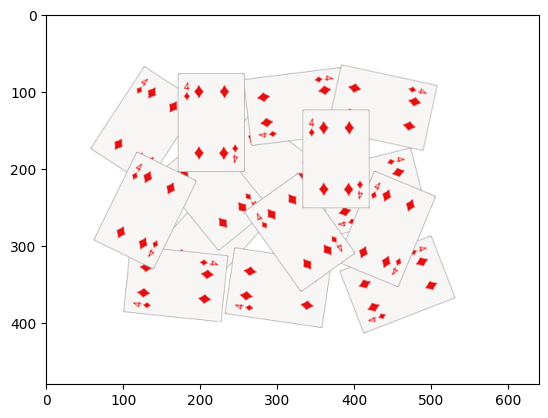

In [4]:
img_src = cv2.cvtColor(cv2.imread("data/cards.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img_src)

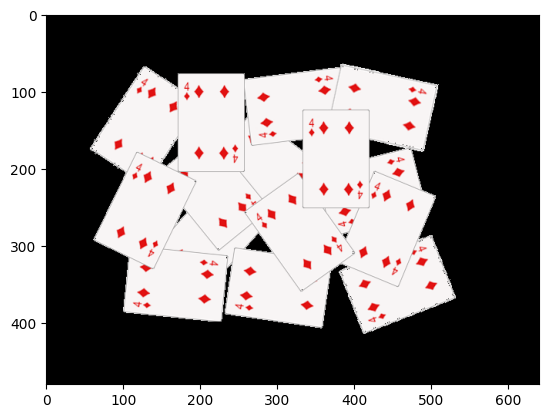

In [5]:
# Change the background from white to black, since that will help later to extract
# better results during the use of Distance Transform
img = img_src.copy()
img[np.all(img == 255, axis=2)] = 0

plt.imshow(img);

Text(0.5, 1.0, 'New Sharped Image')

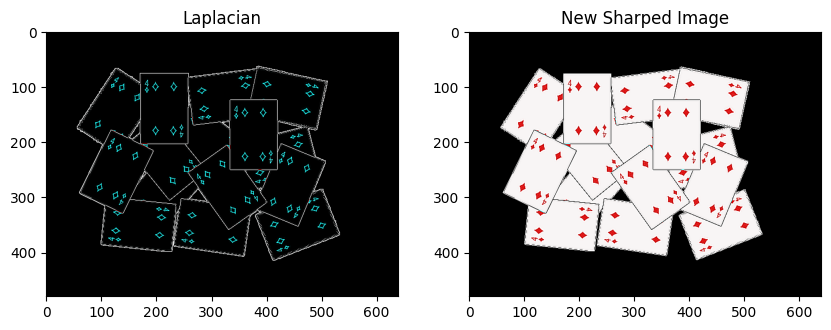

In [6]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array(
    [[  1,  1,  1],
     [  1, -8,  1],
     [  1,  1,  1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
sharp = np.float32(img)
imgResult = sharp - imgLaplacian

# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(imgLaplacian)
plt.title('Laplacian')
plt.subplot(122)
plt.imshow(imgResult)
plt.title('New Sharped Image')

### Бинаризация изображения

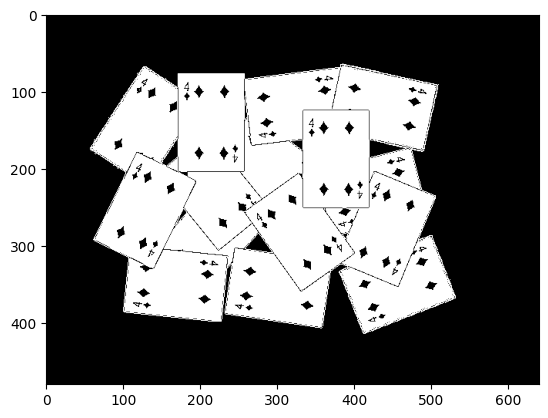

In [7]:
# Create binary image from source image
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw, cmap="Greys_r")

### Distance transform

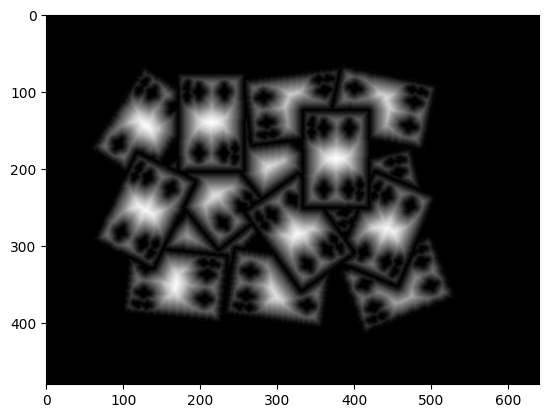

In [8]:
# Perform the distance transform algorithm
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.imshow(dist, cmap="Greys_r")

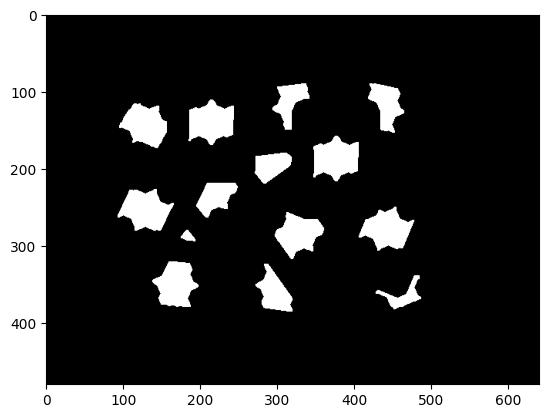

In [9]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.imshow(dist, cmap="Greys_r");

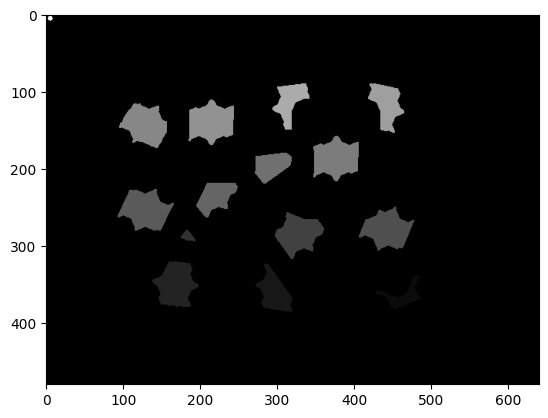

In [10]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(
        markers,   # image
        contours,  # contours list
        i,         # contour index to draw
        (i+1),     # color (fill value)
        -1,        # thickness (if negative - fill the contour)
    )
# Draw the background marker
cv2.circle(
    markers,        # image
    (5,5),          # center
    3,              # radius
    (255,255,255),  # color
    -1,             # thickness (if negative - fill)
)

markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u, cmap="Greys_r");

### Алгоритм Watershed

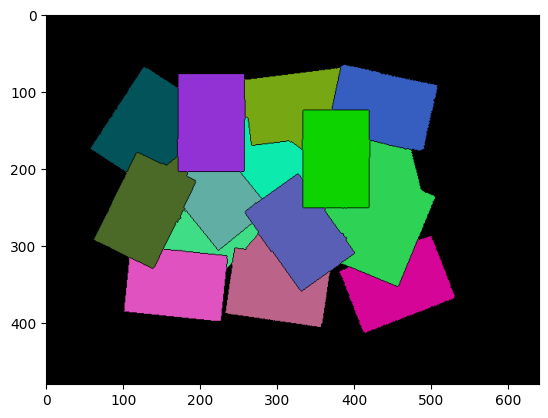

In [11]:
# Perform the watershed algorithm
cv2.watershed(imgResult, markers)

mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
# plt.imshow(mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

# Visualize the final image
plt.imshow(dst);

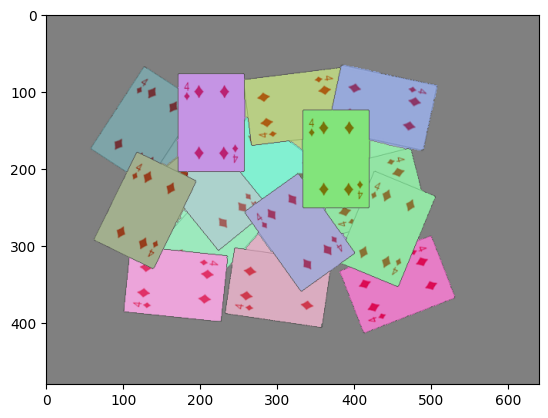

In [12]:
blended = cv2.addWeighted(img_src, 0.5, dst, 0.5, 0.0)
plt.imshow(blended);

# Домашнее задание: подсчет количества пальцев

Вам предлагается реализовать алгоритм, подсчитывающий количество пальцев.

Один из возможных вариантов решения:
- Получить бинаризованное изображение и найти контур руки;
- Построить выпуклый контур функцией `cv2.convexHull` - https://docs.opencv.org/3.4/d7/d1d/tutorial_hull.html
- Найти дефекты выпуклости контура функцией [`cv2.convexityDefects`](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gada4437098113fd8683c932e0567f47ba)
- После некоторой фильтрации дефектов, их число будет напрямую коррелировать с числом пальцев.

**Требования:**
1. Продемонстрируйте работоспособность алгоритма на любом числе пальцев (от 0 до 5).
2. Используйте фото своей руки для демонстрации (предложенное фото лишь для отладки).

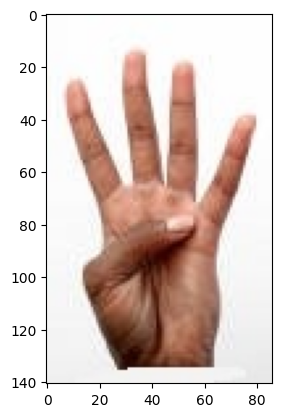

In [52]:
img = cv2.cvtColor(cv2.imread("data/finger_4.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

Blur помогает уменьшить фоновый шум, что в последствие поможет при переводе изображения в чёрные и белые пиксели

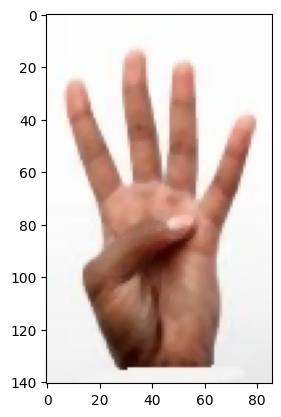

In [53]:
blured_img = cv2.medianBlur(img, 3)
plt.imshow(blured_img)
plt.show()

### Бинаризуем изображение

In [54]:
bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blured_bw = cv2.cvtColor(blured_img, cv2.COLOR_BGR2GRAY)

Без blur виден фоновый шум

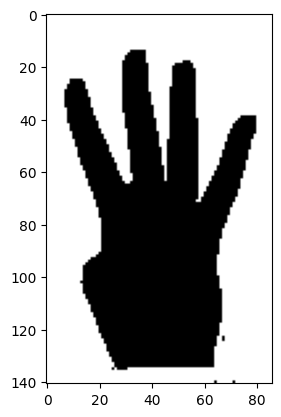

In [55]:
_, bw_with_holes = cv2.threshold(bw, 227, 255, cv2.THRESH_BINARY)

plt.imshow(bw_with_holes, cmap="gray")
plt.show()

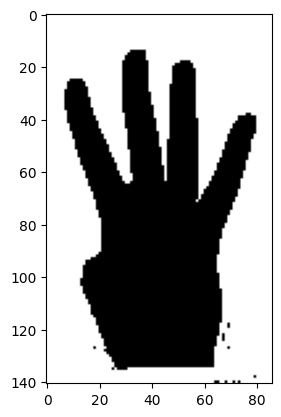

In [56]:
_, bw_with_back_noise = cv2.threshold(bw, 230, 255, cv2.THRESH_BINARY)

plt.imshow(bw_with_back_noise, cmap="gray")
plt.show()

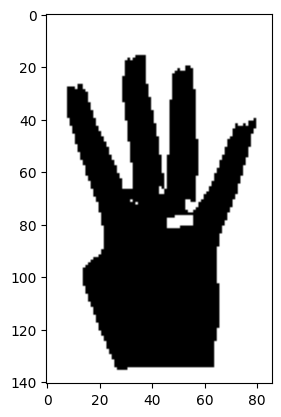

In [57]:
_, bw_with_large_white_regions = cv2.threshold(bw, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.imshow(bw_with_large_white_regions, cmap="gray")
plt.show()

С blur получаем изображение без шумов с обычным отсевом пикселей по трешхолду

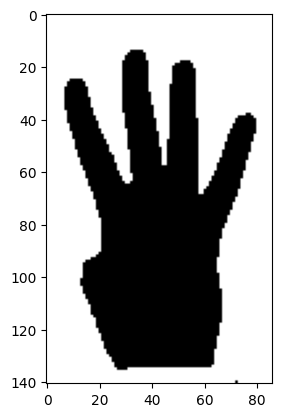

In [58]:
_, blurred_bw = cv2.threshold(blured_bw, 231, 255, cv2.THRESH_BINARY)

plt.imshow(blurred_bw, cmap="gray")
plt.show()

Можем дополнительно сделать erode, чтобы убрать белые точки на руке

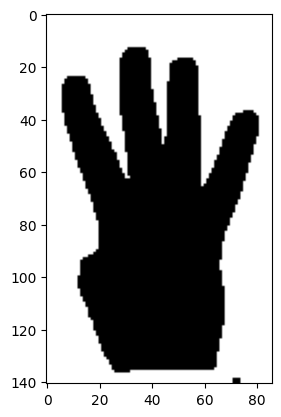

In [59]:
n = 3
kernel = np.ones((n,n),np.uint8)
dilation = cv2.erode(blurred_bw, kernel, iterations = 1)
# closing = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=3)

plt.imshow(dilation, cmap="gray")
plt.show()

## Ищем все контуры и выбираем среди них самый длинный

Counturs found:  2
Choosing the larges contour


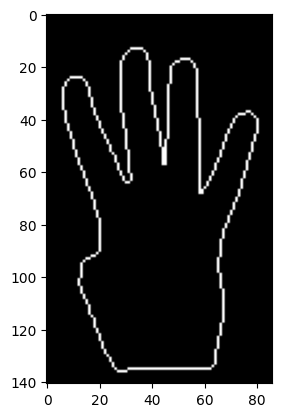

In [60]:
contours, hierarchy = cv2.findContours(blurred_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print("Counturs found: ", len(contours))
print(f"Choosing the larges contour")

largest_countour = contours[0]
for contour in contours:
    largest_countour = contour if len(contour) > len(largest_countour) else largest_countour

# arclen = cv2.arcLength(largest_countour, True)
# eps = 0.0005
# epsilon = arclen * eps
# largest_countour = cv2.approxPolyDP(largest_countour, epsilon, True)

img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
cv2.drawContours(img_contours, [largest_countour], -1, (255,255,255), 1)

plt.imshow(img_contours, cmap="gray")
plt.show()

## Получаем выпуклую оболочку

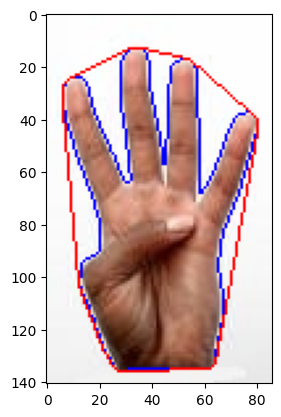

In [61]:
hull = cv2.convexHull(largest_countour, returnPoints = False)
hull_points = cv2.convexHull(largest_countour, returnPoints = True)

cv2.drawContours(img, [largest_countour], -1, (0,0,255), 1)
cv2.drawContours(img, [hull_points], -1, (255,0,0), 1)

plt.imshow(img, cmap="gray")

## Получаем дефекты

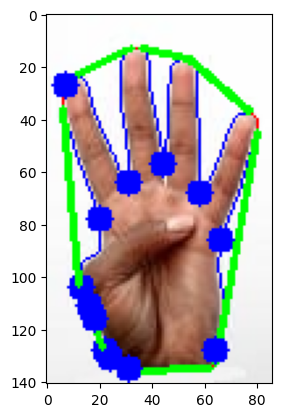

In [62]:
defects = cv2.convexityDefects(largest_countour, hull)

img_with_defects = img.copy()

for defect in defects:
    s,e,f,d = defect[0]
    start = tuple(largest_countour[s][0])
    end = tuple(largest_countour[e][0])
    far = tuple(largest_countour[f][0])
    cv2.line(img_with_defects,start,end,[0,255,0],2)
    cv2.circle(img_with_defects,far,5,[0,0,255],-1)
 
plt.imshow(img_with_defects)

Среди всех полученных точек выбираем только те, которые находятся далеко от выпуклой оболочки

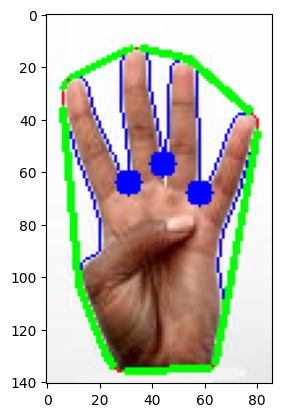

In [64]:
defect_min_dist_from_hull = 5000
img_with_defects = img.copy()

for defect in defects:
    s,e,f,d = defect[0]
    start = tuple(largest_countour[s][0])
    end = tuple(largest_countour[e][0])
    far = tuple(largest_countour[f][0])
    cv2.line(img_with_defects,start,end,[0,255,0],2)
    if d > defect_min_dist_from_hull:
        cv2.circle(img_with_defects,far,5,[0,0,255],-1)
 
plt.imshow(img_with_defects)

## Итого

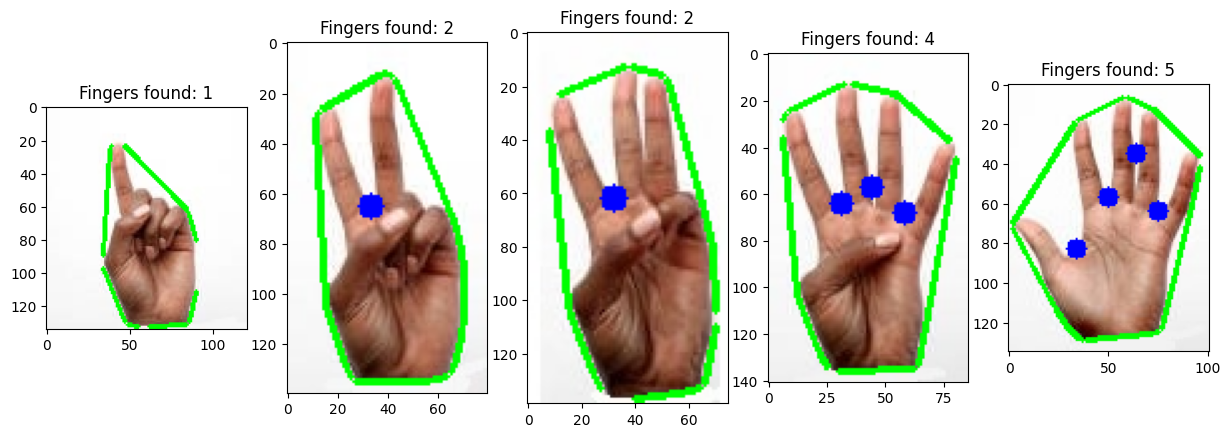

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(15,5))

images = [cv2.cvtColor(cv2.imread(f"data/finger_{i}.jpg"), cv2.COLOR_BGR2RGB) for i in range(1,6)]
for img, ax in zip(images, axes):
    blured_img = cv2.medianBlur(img, 3)

    # Img to black and white
    bw = cv2.cvtColor(blured_img, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(bw, 231, 255, cv2.THRESH_BINARY)

    # Find countour
    contours, hierarchy = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Select only the larges countour
    largest_countour = contours[0]
    for contour in contours:
        largest_countour = contour if len(contour) > len(largest_countour) else largest_countour
        
    # Create convex hull
    hull = cv2.convexHull(largest_countour, returnPoints = False)

    # Detect defects
    defect_min_dist_from_hull = 5000
    fingers_found = 0
    defects = cv2.convexityDefects(largest_countour, hull)
    for defect in defects:
        s,e,f,d = defect[0]
        start = tuple(largest_countour[s][0])
        end = tuple(largest_countour[e][0])
        far = tuple(largest_countour[f][0])
        
        cv2.line(img,start,end,[0,255,0],2)

        # Remove all points close to convex hull
        if d > defect_min_dist_from_hull:
            cv2.circle(img,far,5,[0,0,255],-1)
            fingers_found+=1

    ax.imshow(img)
    ax.set_title(f"Fingers found: {fingers_found+1}")